In [2]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [ ]:
# utilities for case handling, safe imports, and loading
from pathlib import Path
import warnings

# base path handling
BASE = Path("../data/raw/BraTS-GLI/train/ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData/").resolve()
assert BASE.exists(), f"Base path not found: {BASE}" #assert BASE.exists() → stops the program if the folder doesn’t exist

#Each patient’s MRI scans live inside a folder like: BraTS-GLI-12345
#This function returns a sorted list of all case folders
def list_cases(base: Path):
    return sorted([d.name for d in base.iterdir() if d.is_dir() and d.name.startswith("BraTS")])
#Prints how many patients were found and shows one example case
CASES = list_cases(BASE)
print(f"Found {len(CASES)} cases. Example: {CASES[0] if CASES else 'NONE'}")

# optional interactive selection
#Tries to show a dropdown menu to select a case If widgets don’t work, it automatically picks the first case
try:
    import ipywidgets as W
    case_dropdown = W.Dropdown(options=CASES, description='Case:', value=CASES[0] if CASES else None)
    display(case_dropdown)
    selected_case = case_dropdown.value
except Exception:
    warnings.warn("ipywidgets not available; falling back to first case")
    selected_case = CASES[0] if CASES else None

assert selected_case is not None, "No cases found in base directory"
sel_path = BASE / selected_case
print("Selected:", selected_case)

# loader helpers
def _load_float32(path: Path): #Load any modality as float32 (to save memory)
    img = nib.load(str(path))
    data = np.asanyarray(img.dataobj, dtype=np.float32)
    return img, data

def _load_mask(path: Path): #Load any mask as int16 (to save memory)
    img = nib.load(str(path))
    data = np.asanyarray(img.dataobj)
    # Some masks may be float in files; coerce safely
    data = data.astype(np.int16, copy=False)
    return img, data

#MRI scans = floating-point values
#Masks = integers (0, 1, 2, 4) that represent tumor regions

'''| File ending | Meaning                     |
| ----------- | --------------------------- |
| `t2f`       | FLAIR                       |
| `t1n`       | T1 native                   |
| `t1c`       | T1 contrast (CE)            |
| `t2w`       | T2 weighted                 |
| `seg`       | segmentation (tumor labels) |
'''

def load_modalities(case_dir: Path, case_id: str):
    f_flair = case_dir / f"{case_id}-t2f.nii.gz"
    f_t1n  = case_dir / f"{case_id}-t1n.nii.gz"
    f_t1c  = case_dir / f"{case_id}-t1c.nii.gz"
    f_t2w  = case_dir / f"{case_id}-t2w.nii.gz"
    f_seg  = case_dir / f"{case_id}-seg.nii.gz"
    for p in [f_flair, f_t1n, f_t1c, f_t2w, f_seg]:
        assert p.exists(), f"Missing file: {p}"
    i_flair, flair = _load_float32(f_flair)
    i_t1n,   t1    = _load_float32(f_t1n)
    i_t1c,   t1ce  = _load_float32(f_t1c)
    i_t2w,   t2    = _load_float32(f_t2w)
    i_seg,   mask  = _load_mask(f_seg)
    return (i_flair, i_t1n, i_t1c, i_t2w, i_seg), (flair, t1, t1ce, t2, mask)

imgs, (flair2, t12, t1ce2, t22, mask2) = load_modalities(sel_path, selected_case)

# basic sanity checks
shapes = {k:v.shape for k,v in dict(FLAIR=flair2, T1=t12, T1CE=t1ce2, T2=t22, MASK=mask2).items()}
print("Shapes:", shapes)

# Affine consistency
A = [im.affine for im in imgs]
ok_affine = all(np.allclose(A[0], a) for a in A[1:])
print("Affine consistent:", ok_affine)

Found 1251 cases. Example: BraTS-GLI-00000-000
Selected: BraTS-GLI-00000-000
Shapes: {'FLAIR': (240, 240, 155), 'T1': (240, 240, 155), 'T1CE': (240, 240, 155), 'T2': (240, 240, 155), 'MASK': (240, 240, 155)}
Affine consistent: True


/var/folders/sf/hhdtnw716rj5hq5_klgcg8jm0000gn/T/ipykernel_92636/2570646900.py:22: UserWarning: ipywidgets not available; falling back to first case
  warnings.warn("ipywidgets not available; falling back to first case")


In [17]:
# label introspection
labels, counts = np.unique(mask2, return_counts=True)
print("Mask labels and voxel counts:")
for l, c in zip(labels, counts):
    print(f"  {int(l)}: {int(c)}")

# derived regions
WT = (mask2 > 0)
TC = np.isin(mask2, [1,4])
ET = (mask2 == 4)
print({
    'WT voxels': int(WT.sum()),
    'TC voxels': int(TC.sum()),
    'ET voxels': int(ET.sum()),
})

Mask labels and voxel counts:
  0: 8870695
  1: 11738
  2: 12836
  3: 32731
{'WT voxels': 57305, 'TC voxels': 11738, 'ET voxels': 0}


In [18]:
# intensity normalization utilities

def robust_clip(x, pmin=0.5, pmax=99.5):
    lo = np.percentile(x[np.isfinite(x)], pmin)
    hi = np.percentile(x[np.isfinite(x)], pmax)
    return np.clip(x, lo, hi)


def norm_minmax(x):
    x = x - x.min()
    denom = x.max() if x.max() != 0 else 1.0
    return x / denom


def normalize_modality(x):
    x = robust_clip(x)
    x = norm_minmax(x)
    return x.astype(np.float32, copy=False)

flair_n = normalize_modality(flair2)
t1_n    = normalize_modality(t12)
t1ce_n  = normalize_modality(t1ce2)
t2_n    = normalize_modality(t22)

print("Normalized stats (min,max):",
      (float(flair_n.min()), float(flair_n.max())),
      (float(t1_n.min()), float(t1_n.max())),
      (float(t1ce_n.min()), float(t1ce_n.max())),
      (float(t2_n.min()), float(t2_n.max())))

Normalized stats (min,max): (0.0, 1.0) (0.0, 1.0) (0.0, 1.0) (0.0, 1.0)


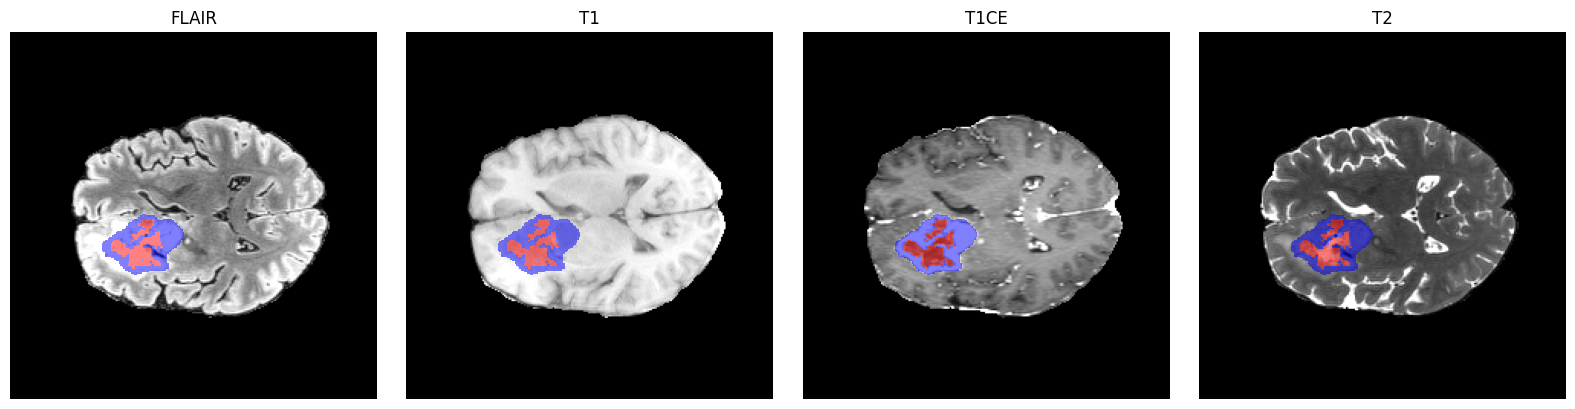

In [20]:
# visualization: overlay mask on modalities
from matplotlib.colors import ListedColormap

# simple label colormap (0 transparent, 1 red, 2 green, 4 blue)
colors = np.array([
    [0.0, 0.0, 0.0, 0.0],  # 0 background transparent
    [1.0, 0.0, 0.0, 0.5],  # 1 NCR/NET
    [0.0, 1.0, 0.0, 0.4],  # 2 Edema
    [0.0, 0.0, 0.0, 0.0],  # 3 unused
    [0.0, 0.0, 1.0, 0.5],  # 4 ET
])
label_cmap = ListedColormap(colors)

sl = flair_n.shape[2] // 2
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for ax, img, title in zip(
    axs,
    [flair_n, t1_n, t1ce_n, t2_n],
    ["FLAIR", "T1", "T1CE", "T2"],
):
    ax.imshow(img[:, :, sl], cmap='gray')
    ax.imshow(mask2[:, :, sl], cmap=label_cmap, interpolation='nearest')
    ax.set_title(title)
    ax.axis('off')
plt.tight_layout(); plt.show()

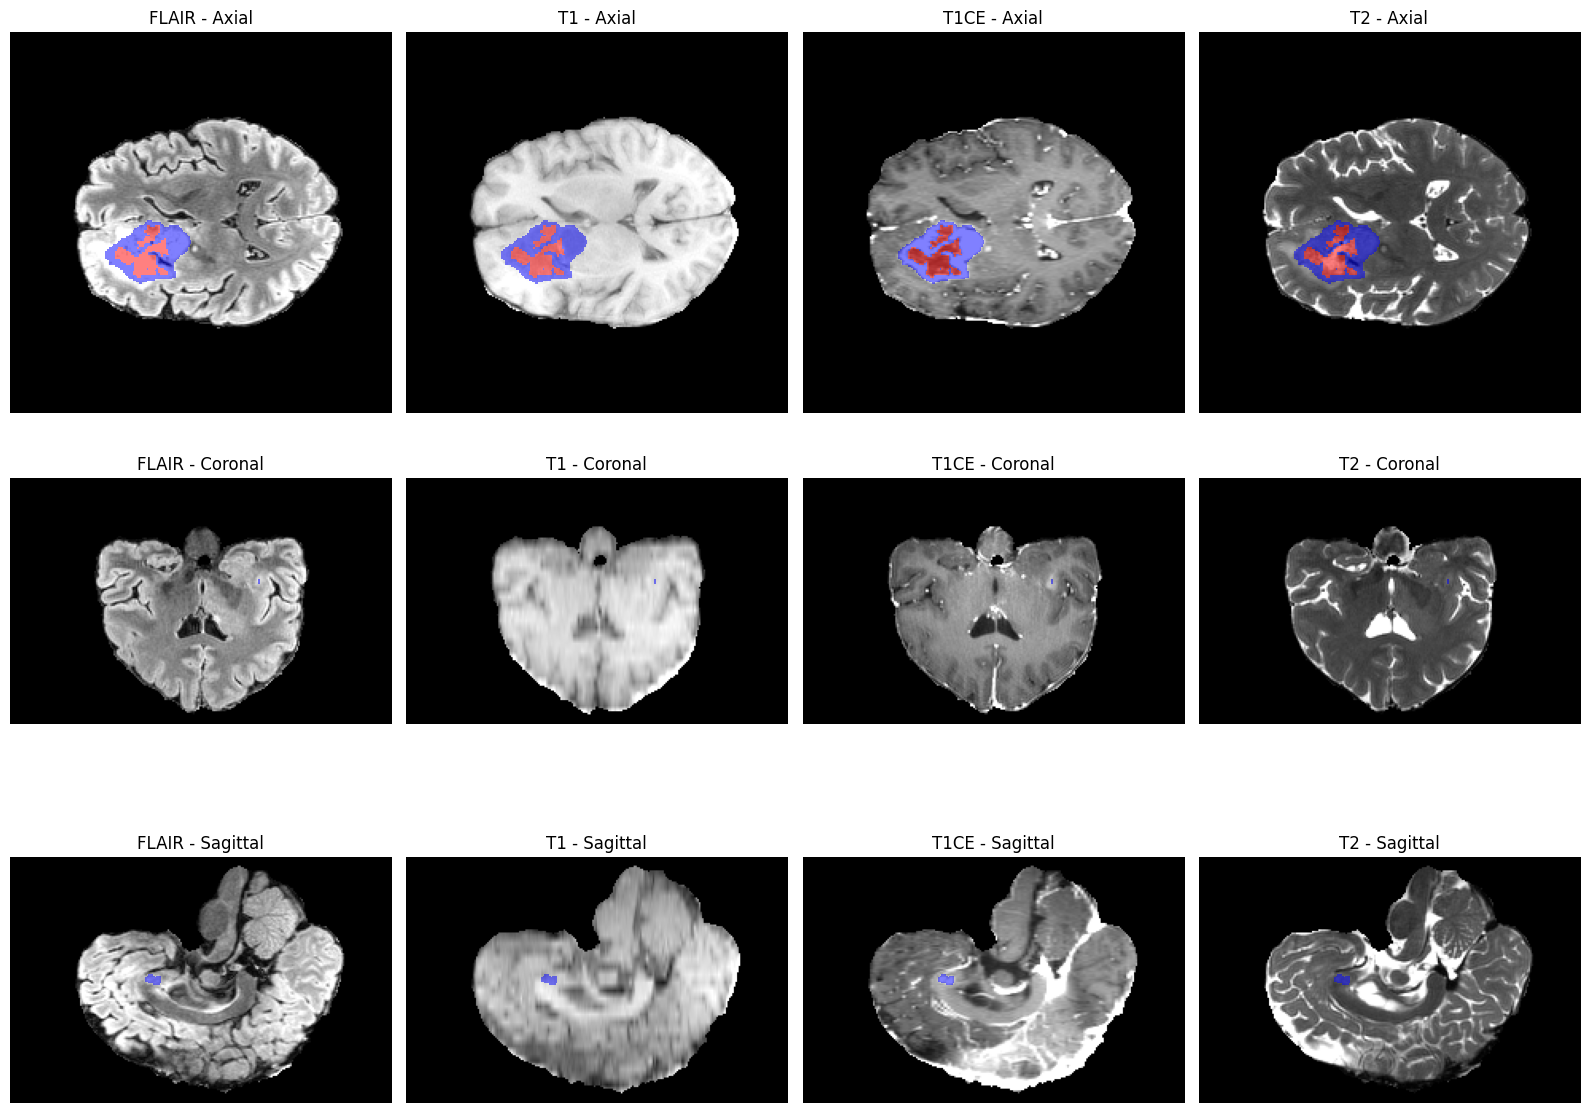

In [21]:
# orthogonal views (axial, coronal, sagittal) with overlay
sl_a = flair_n.shape[2] // 2
sl_c = flair_n.shape[1] // 2
sl_s = flair_n.shape[0] // 2

fig, axs = plt.subplots(3, 4, figsize=(16, 12))
views = [
    (lambda v: v[:, :, sl_a], lambda m: m[:, :, sl_a], 'Axial'),
    (lambda v: v[:, sl_c, :].T, lambda m: m[:, sl_c, :].T, 'Coronal'),
    (lambda v: v[sl_s, :, :].T, lambda m: m[sl_s, :, :].T, 'Sagittal'),
]
modalities = [(flair_n, 'FLAIR'), (t1_n, 'T1'), (t1ce_n, 'T1CE'), (t2_n, 'T2')]
for r, (slice_fun, mask_fun, vname) in enumerate(views):
    for c, (vol, name) in enumerate(modalities):
        ax = axs[r, c]
        ax.imshow(slice_fun(vol), cmap='gray')
        ax.imshow(mask_fun(mask2), cmap=label_cmap, interpolation='nearest')
        ax.set_title(f"{name} - {vname}")
        ax.axis('off')
plt.tight_layout(); plt.show()

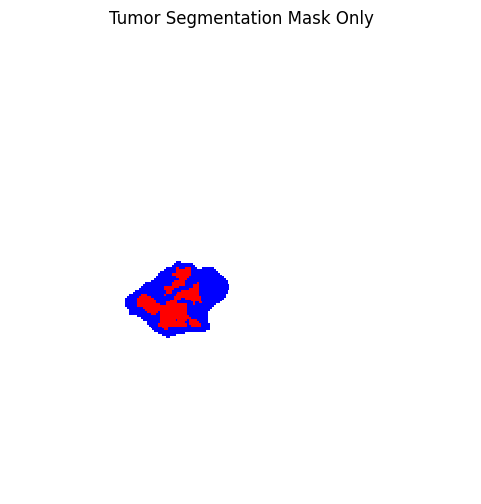

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# pick a slice number (middle of the brain)
sl = mask2.shape[2] // 2

# create a simple color map for labels
from matplotlib.colors import ListedColormap

colors = np.array([
    [0.0, 0.0, 0.0, 0.0],   # 0 → transparent
    [1.0, 0.0, 0.0, 1.0],   # 1 → red (necrotic/non-enhancing tumor)
    [0.0, 1.0, 0.0, 1.0],   # 2 → green (edema)
    [0.0, 0.0, 0.0, 0.0],   # 3 → unused
    [0.0, 0.0, 1.0, 1.0],   # 4 → blue (enhancing tumor)
])

mask_cmap = ListedColormap(colors)

plt.figure(figsize=(6,6))
plt.imshow(mask2[:, :, sl], cmap=mask_cmap, interpolation='nearest')
plt.title("Tumor Segmentation Mask Only")
plt.axis('off')
plt.show()
